# Clustering 

In [4]:
import matplotlib.pyplot as plt
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1.) Create User Summary DataFrame
Group by users and combine their text features

In [5]:
df = pd.read_csv('data/million_df_v2.csv', index_col=0)
df['user_description'].fillna(' ', inplace=True)
#are any screen names missing? if not, use these as the global key/index
df['user_screen_name'].isna().nunique()
#all screen names are present. some are floats though? (from error below)
#ensure that all usernames are strings
df['user_screen_name'] = df['user_screen_name'].astype('str')
df['user_screen_name'].dtypes

1

dtype('O')

In [6]:
features = ['user_location',
       'favorite_count', 
        'retweet_count', 
       'text', 
       'user_screen_name', 'user_description',
       'user_followers_count', 
       'user_name']


final_df = df[features]
final_df = final_df[final_df['text'].isna()==False]
final_df['user_location'].fillna(value=' ', inplace=True)
final_df['user_location']
# add the user_location text to the user_description text
final_df['user_description'] = final_df['user_description'] + ' ' + final_df['user_location'] 

0           adelaide south australia
1           winnipeg manitoba canada
2                       united state
3                       united state
4                       united state
                     ...            
605839                  united state
605840                panama city fl
605841            south carolina usa
605842    anywhere usa ghana england
605843                  united state
Name: user_location, Length: 581444, dtype: object

In [7]:
#group by username and select only the text columns
combined_text = final_df.groupby(['user_screen_name']).apply(lambda x: ' '.join(x['text']))
combined_text.rename('combined_text',inplace=True)
final_df = final_df.merge(combined_text, left_on='user_screen_name',right_index=True)
#new df for user summaries
user_summary = final_df.groupby(['user_screen_name', 'user_description', 'combined_text', 'user_location']).mean() 
user_summary.reset_index(inplace=True)
user_summary

user_screen_name
000120o         meryl streep celebrated breaking glass ceiling...
0001Angel       sander `` hillary clinton must become next pre...
000Dillon000    muslim talking trump disrespecting woman read ...
0014Priya              latest screenwriting tvseries movie thanks
001Leslie                                  wow .. moving touching
                                      ...                        
zzzdeprived     amazing job ca wait see win `` america great a...
zzzdogman       bernie taught anything love money especially e...
zzzpills        subway filled sandernistas never miss opportun...
zzzzalex                                             mostly false
zzzzzabeth         much stronger together pas torch iconic sister
Name: combined_text, Length: 246770, dtype: object

,user_screen_name,user_description,combined_text,user_location,favorite_count,retweet_count,user_followers_count
0,000120o,italia-roma,meryl streep celebrated breaking glass ceiling...,italia-roma,0.0,19.00,3447.0
1,0001Angel,liberal,sander `` hillary clinton must become next pre...,,0.0,166.00,639.0
2,000Dillon000,independent christian conservative army vet ar...,muslim talking trump disrespecting woman read ...,,0.0,179.50,4181.0
3,0014Priya,screenwriter yogini movie art book music natur...,latest screenwriting tvseries movie thanks,netherlands,0.0,0.00,524.0
4,001Leslie,always love dad,wow .. moving touching,,0.0,0.00,162.0
...,...,...,...,...,...,...,...
246805,zzzdeprived,ohio,amazing job ca wait see win `` america great a...,ohio,0.0,55.50,158.0
246806,zzzdogman,deplorable dreg cagey old vet- reagan trump ma...,bernie taught anything love money especially e...,colorado,0.0,289.50,11748.5
246807,zzzpills,lover mother earth bernie sander austin tx,subway filled sandernistas never miss opportun...,austin tx,0.0,273.75,357.0
246808,zzzzalex,,mostly false,,0.0,453.00,10.0


In [8]:
user_summary.combined_text.apply(lambda x: len(x)).mean()
# the average combined text length is 128 chars (standard length of a tweet)

105.28022365382277

In [9]:
# how many users are missing descriptions? 38,602
user_summary[user_summary['user_description']==' ']

,user_screen_name,user_description,combined_text,user_location,favorite_count,retweet_count,user_followers_count


# Vectorize Tweet Text
(using Gensim + GloVe)

In [10]:
!pip install gensim

In [11]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim.downloader as api
import gensim
from gensim.models.word2vec import Word2Vec

In [12]:
#start with the glove-25 and increase if needed (50, 100, 200 available)
glove_25 = api.load('glove-twitter-25')
glove_100 = api.load('glove-twitter-200')

2020-06-10 21:42:03,300 : INFO : loading projection weights from /root/gensim-data/glove-twitter-25/glove-twitter-25.gz
2020-06-10 21:42:37,375 : INFO : loaded (1193514, 25) matrix from /root/gensim-data/glove-twitter-25/glove-twitter-25.gz
2020-06-10 21:42:37,486 : INFO : loading projection weights from /root/gensim-data/glove-twitter-200/glove-twitter-200.gz
2020-06-10 21:46:09,117 : INFO : loaded (1193514, 200) matrix from /root/gensim-data/glove-twitter-200/glove-twitter-200.gz


In [13]:
# take a look at the vocabulary
#for i, word in enumerate(glove_25.vocab):
#    if i == 20:
#        break
#    print(word)
    
glove_25.most_similar(['trump', 'maga'])
glove_25.most_similar(['clinton'])
glove_25['trump']


# try to vectorize a word
#sample_text = user_summary['combined_text'][0].split()
#sample_text
#glove_25.word_vec(sample_text[0])


2020-06-10 21:46:09,124 : INFO : precomputing L2-norms of word weight vectors


[('troy', 0.9075865745544434),
 ('madison', 0.8607248067855835),
 ('savannah', 0.8565793037414551),
 ('charlotte', 0.8528245687484741),
 ('sierra', 0.8500258326530457),
 ('chester', 0.848908543586731),
 ('clark', 0.8480731844902039),
 ('orlando', 0.835505485534668),
 ('mills', 0.8341056108474731),
 ('jax', 0.8334002494812012)]

[('hillary', 0.967746376991272),
 ('kerry', 0.9634538292884827),
 ('christie', 0.9525367021560669),
 ('barack', 0.9524132013320923),
 ('president', 0.9378829598426819),
 ('reid', 0.9331226944923401),
 ('obama', 0.928589940071106),
 ('biden', 0.9253028631210327),
 ('reagan', 0.9235118627548218),
 ('jonathan', 0.9217425584793091)]

array([-0.56174 ,  0.69419 ,  0.16733 ,  0.055867, -0.26266 , -0.6303  ,
       -0.28311 , -0.88244 ,  0.57317 , -0.82376 ,  0.46728 ,  0.48607 ,
       -2.1942  , -0.41972 ,  0.31795 , -0.70063 ,  0.060693,  0.45279 ,
        0.6564  ,  0.20738 ,  0.84496 , -0.087537, -0.38856 , -0.97028 ,
       -0.40427 ], dtype=float32)

In [14]:
#write a function to loop through tweets and vectorize each word
sentences = user_summary['combined_text']

model = glove_25

def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
    if sent_vec == []:
        return np.zeros((25,))
    else:
        return np.asarray(sent_vec) / numw

X=[]
for sentence in sentences:
    X.append(sent_vectorizer(sentence, model))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [15]:
X[157841]

array([ 0.6405283 ,  0.18502013, -0.25252876, -0.4381471 , -0.1547939 ,
        0.05634296, -0.08397209,  1.7334558 ,  0.17192627, -0.03527125,
       -0.6694735 , -0.91430247, -3.8706784 ,  0.04821457, -0.8953895 ,
       -0.39318782, -0.96859694, -0.03069654, -1.0092835 ,  0.41093636,
       -0.35343733, -0.46934995,  0.3778637 ,  0.29600564,  0.22051191],
      dtype=float32)

In [ ]:
shapes = {arr.shape for arr in X}
shapes

indexes = [arr.shape == (0,) for arr in X]
#indexes.index(True)

user_summary.iloc[157841]['combined_text']

#glove_25['27']

In [17]:
X2 = np.stack(X)
X2.shape

(246810, 25)

### Experiment with # of clusters

# Cluster Users

In [18]:
import numpy as np 
from sklearn import cluster
from sklearn import metrics


NUM_CLUSTERS=10

kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [19]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
  
print ("Cluster id labels for inputted data")
print (labels)
#print ("Centroids data")
#print (centroids)
  
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
  
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
  
print ("Silhouette_score: ")
print (silhouette_score)

Cluster id labels for inputted data
[0 8 8 ... 8 5 1]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-36013.5800265956
Silhouette_score: 
0.07129748825741677


In [20]:
labels.shape

(246810,)

In [21]:
# join cluster labels on the user_summary dataframe
user_summary['cluster'] = labels
user_summary.head()

,user_screen_name,user_description,combined_text,user_location,favorite_count,retweet_count,user_followers_count,cluster
0,000120o,italia-roma,meryl streep celebrated breaking glass ceiling...,italia-roma,0.0,19.0,3447.0,0
1,0001Angel,liberal,sander `` hillary clinton must become next pre...,,0.0,166.0,639.0,8
2,000Dillon000,independent christian conservative army vet ar...,muslim talking trump disrespecting woman read ...,,0.0,179.5,4181.0,8
3,0014Priya,screenwriter yogini movie art book music natur...,latest screenwriting tvseries movie thanks,netherlands,0.0,0.0,524.0,0
4,001Leslie,always love dad,wow .. moving touching,,0.0,0.0,162.0,3


In [22]:
#sizes of clusters
label_set = list(set(labels))
for label in label_set:
    print('{}:'.format(label), user_summary[user_summary['cluster'] == label].shape[0])
    
label_set.sort()
for label in label_set:
    print('{}:'.format(label), (user_summary[user_summary['cluster'] == float(label)].shape[0] / user_summary.shape[0])*100, '%')

0: 48890
1: 35759
2: 36455
3: 8950
4: 10828
5: 3641
6: 19657
7: 522
8: 60417
9: 21691
0: 19.808759774725498 %
1: 14.488472914387584 %
2: 14.770471212673716 %
3: 3.6262712207771157 %
4: 4.387180422187107 %
5: 1.475223856407763 %
6: 7.964426076739192 %
7: 0.21149872371459827 %
8: 24.47915400510514 %
9: 8.788541793282281 %


### Save labeled cluster use_summary

In [23]:
user_summary.to_csv('data/clustered_user_summary.csv')

### TF-IDF to get topics for clusters:

In [24]:
# tf-idf on clusters to get topics 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

vectorizer = TfidfVectorizer(max_features=10000)


X = user_summary['user_description'] + ' ' + user_summary['combined_text']
y = user_summary['cluster']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [25]:
X.head()

0      italia-roma meryl streep celebrated breaking...
1    liberal   sander `` hillary clinton must becom...
2    independent christian conservative army vet ar...
3    screenwriter yogini movie art book music natur...
4             always love dad   wow .. moving touching
dtype: object

In [26]:
X_train.size
X_train.shape
feature_names=vectorizer.get_feature_names()
len(feature_names)
# for reference, community df shape = (19724, 65248) size = 814271

3836202

(185107, 10000)

10000

In [27]:
# Plot top tf-idf features
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

import matplotlib.pyplot as plt
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time


def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

feature_names=vectorizer.get_feature_names()
top_feats_in_doc(X_train,feature_names,1)

,feature,tfidf
0,hahahaha,0.340110
1,wet,0.339530
2,neutral,0.302275
3,streaming,0.297610
4,bathroom,0.276601
5,holy,0.264886
6,ball,0.264565
7,beer,0.248978
8,gender,0.248661
9,water,0.236556


In [28]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs
dfs=top_feats_by_class(X_train,y_train,feature_names, top_n=25)

In [29]:
len(dfs)

10

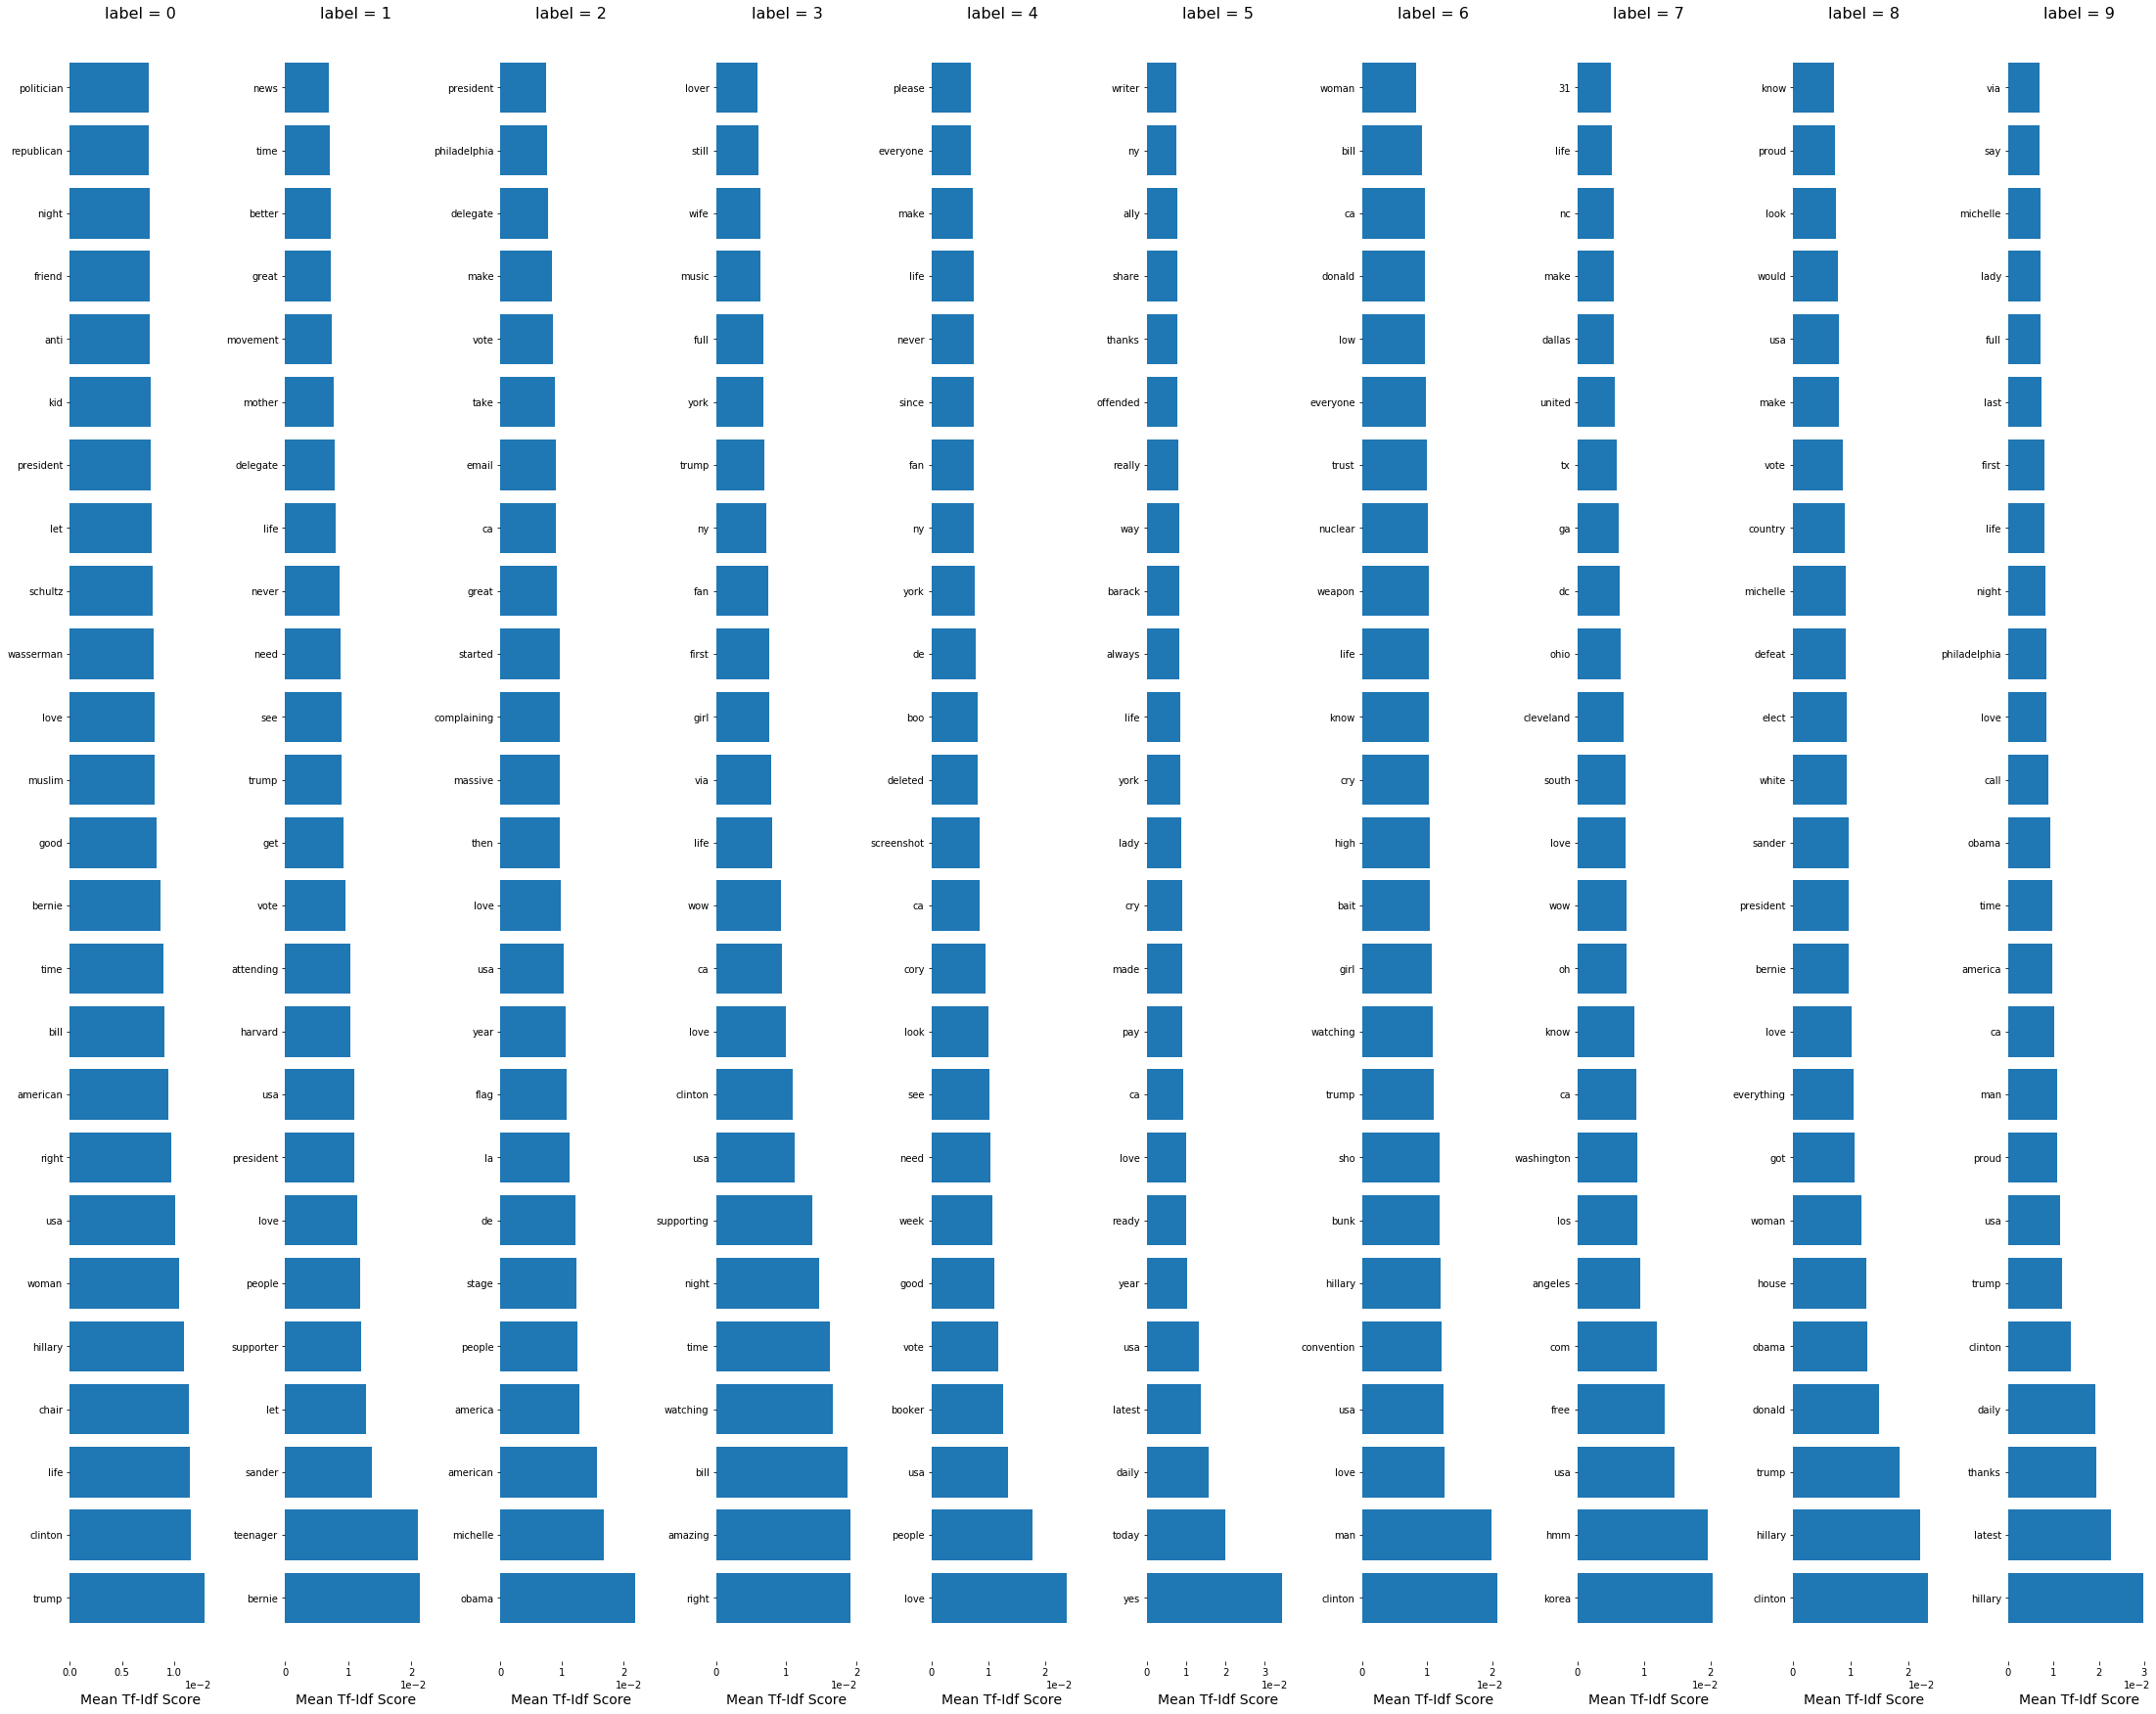

In [30]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(36, 27), facecolor="w",)
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.set_cmap('viridis')
    plt.savefig('data/10_clusters_tfidf.png', dpi=240)
    plt.show()

plot_tfidf_classfeats_h(dfs)

### Plot clusters using the TFIDF Vectors

In [31]:
!pip install yellowbrick

# Benchmark Models

In [32]:
target_names = y.unique().astype('str')
target_names

array(['0', '8', '3', '2', '6', '9', '4', '5', '1', '7'], dtype='<U11')

In [33]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))


        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="auto"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.01)
train time: 3.759s
test time:  0.018s
accuracy:   0.554
dimensionality: 10000
density: 1.000000
classification report:
              precision    recall  f1-score   support

           0       0.54      0.68      0.60     12223
           8       0.53      0.58      0.56      8940
           3       0.54      0.58      0.56      9114
           2       0.57      0.13      0.21      2238
           6       0.62      0.19      0.29      2707
           9       0.59      0.10      0.17       910
           4       0.60      0.33      0.43      4914
           5       0.25      0.01      0.01       130
           1       0.57      0.69      0.63     15104
           7       0.58      0.43      0.49 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 4.148s
test time:  0.020s
accuracy:   0.478
dimensionality: 10000
density: 0.119330
classification report:
              precision    recall  f1-score   support

           0       0.50      0.58      0.54     12223
           8       0.52      0.44      0.48      8940
           3       0.52      0.44      0.48      9114
           2       0.51      0.07      0.12      2238
           6       0.45      0.10      0.17      2707
           9       0.23      0.02      0.04       910
           4       0.57      0.20      0.30      4914
           5       0.02      0.44      0.03       130
           1       0.50      0.73      0.59     15104
           7       0.49      0.35      0.41      5423

    accuracy                           0.48     61703
   macro avg       0.43      0.34      0.32     61703
weighted avg       0.50      0.48      0.46     61703

confusion matrix:
[[ 7104   687   596    38    44    13   152   507  2719   363]
 [ 1231  3974   642    14    85    10   1

In [39]:
results = [('Random Selection', .10, 0.0, 0.0),
 ('KNeighborsClassifier',
  0.23378117757645495,
  0.030571937561035156,
  328.61589765548706),
 ('MultinomialNB',
  0.46519618170915517,
  0.08032870292663574,
  0.017443418502807617),
 ('SGDClassifier', 0.5241722444613715, 2.22265887260437, 0.019926071166992188),
 ('RidgeClassifier',
  0.5544949192097629,
  3.7586288452148438,
  0.017739295959472656),
 ('RandomForestClassifier',
  0.5782863069866944,
  1267.0663478374481,
  5.573012113571167)]
results

[('Random Selection', 0.1, 0.0, 0.0),
 ('KNeighborsClassifier',
  0.23378117757645495,
  0.030571937561035156,
  328.61589765548706),
 ('MultinomialNB',
  0.46519618170915517,
  0.08032870292663574,
  0.017443418502807617),
 ('SGDClassifier', 0.5241722444613715, 2.22265887260437, 0.019926071166992188),
 ('RidgeClassifier',
  0.5544949192097629,
  3.7586288452148438,
  0.017739295959472656),
 ('RandomForestClassifier',
  0.5782863069866944,
  1267.0663478374481,
  5.573012113571167)]

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Score')

<BarContainer object of 6 artists>

<BarContainer object of 6 artists>

<BarContainer object of 6 artists>

([], <a list of 0 Text yticklabel objects>)

Text(-0.3, 0, 'Random Selection')

Text(-0.3, 1, 'KNeighborsClassifier')

Text(-0.3, 2, 'MultinomialNB')

Text(-0.3, 3, 'SGDClassifier')

Text(-0.3, 4, 'RidgeClassifier')

Text(-0.3, 5, 'RandomForestClassifier')

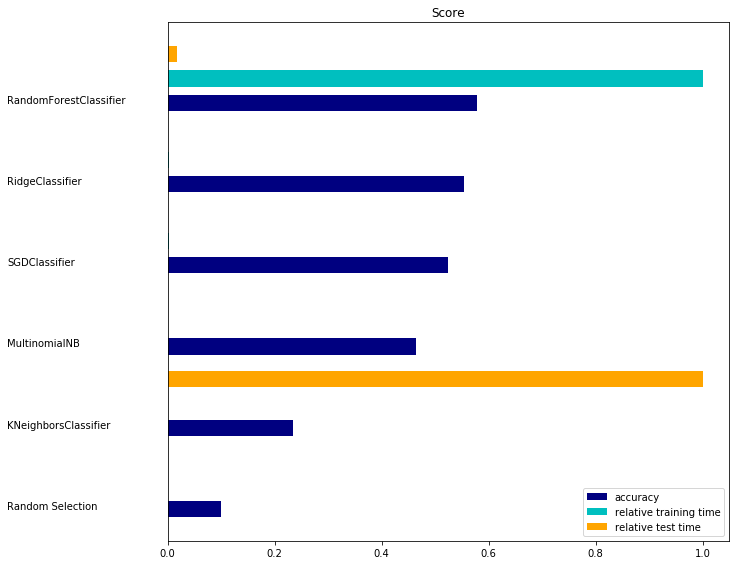

In [40]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="accuracy", color='navy')
plt.barh(indices + .3, training_time, .2, label="relative training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="relative test time", color='orange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()